# PGA Modeling Exploration

Notebook for the exploration of the PGA data set and first pass evaluation of features, relationships and models

In [1]:
import os 
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

from workbench.projects.pga.data.stat_downloader import StatDownloader
from workbench.projects.pga.data.event_downloader import EventDownloader
from workbench.projects.pga.data.data_reader import DataReader

from sklearn.preprocessing import MinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# No warnings about setting value on copy of slice
%matplotlib inline
sns.set(font_scale = 2)
pd.options.mode.chained_assignment = None

data_path_base = os.path.join(os.getenv('DATA'), 'pydata', 'projects', 
                              'pga', 'processed_data')

### Read in File and build train/test sets

In [2]:
# Read in from file
file_name = 'base_data2.csv'
data_csv_path = os.path.join(data_path_base, file_name)
base = pd.read_csv(data_csv_path)
base.columns

Index(['player_name', 'year', 'event_id', 'tourn_id', 'result', 'result_pct',
       'end_date', 'rank_127', 'rank_101', 'rank_102', 'rank_103', 'rank_111',
       'rank_115', 'rank_104', 'rank_190', 'rank_130', 'rank_398', 'rank_426',
       'log_res_pct'],
      dtype='object')

In [26]:
from sklearn.model_selection import train_test_split
feature_cols = [x for x in base.columns if x.find('rank_')==0]
features = base[feature_cols].copy()
targets = base[['result_pct']].copy()
# Split into 70% training and 30% testing set
train_features, test_features, train_labels, test_labels = train_test_split(features, targets, test_size = 0.2, random_state = 123)
print(train_features.shape)
print(test_features.shape)
print(train_labels.shape)
print(test_labels.shape)

(23325, 11)
(5832, 11)
(23325, 1)
(5832, 1)


In [27]:
# Baseline Using Mean Absolute Error 
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))
baseline_pred = np.median(train_labels)
print('The baseline guess is a score of %0.2f' % baseline_pred)
print("Baseline Performance on the test set: MAE = %0.4f" % mae(test_labels, baseline_pred))

The baseline guess is a score of 0.85
Baseline Performance on the test set: MAE = 0.2907


Text(0.5, 1.0, 'Finishing Result Distribution')

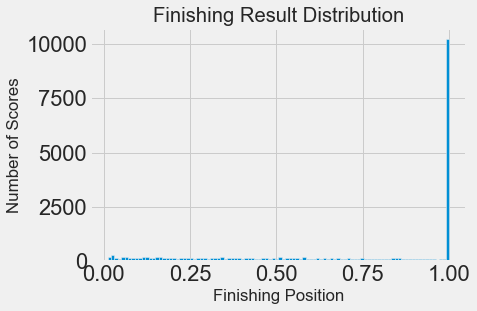

In [29]:
# Object of this study is to predict the ENERGY Star Score (score in df)
figsize(6, 4)

# Histogram of the Energy Star Score
plt.style.use('fivethirtyeight')
plt.hist(train_labels['result_pct'].dropna(), bins = 100)
plt.xlabel('Finishing Position')
plt.ylabel('Number of Scores');
plt.title('Finishing Result Distribution')

## Evaluate and Compare ML Models

### Scale Features 

In [30]:
from sklearn.preprocessing import MinMaxScaler

# Create the scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on the training data
scaler.fit(train_features)

# Transform both the training and testing data
X = scaler.transform(train_features)
X_test = scaler.transform(test_features)

# Convert y to vector
y = np.array(train_labels).reshape(-1)
y_test = np.array(test_labels).reshape(-1)

# Models to Evaluate
Will comapre the following models:
1. Linear Regression
2. Support Vector Machine Regression
3. Random Forest Regression
4. Gradient Boosting Regression
5. K-Nearest Neighbors Regression

Using sklearn defaults for the majority of these models, which should perform decently.  These should be optimized in any real study

In [31]:
# Helper function for model eval
# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X, y)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    
    # Return the performance metric
    return model_mae

In [32]:
# Linear Regression
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)

# SVM Regression
svm = SVR(C = 1000, gamma = 0.1)
svm_mae = fit_and_evaluate(svm)

# Random Forest
random_forest = RandomForestRegressor(random_state=60, n_estimators=20)
random_forest_mae = fit_and_evaluate(random_forest)

# Gradient Boosted Regression
gradient_boosted = GradientBoostingRegressor(random_state=60)
gradient_boosted_mae = fit_and_evaluate(gradient_boosted)

# K-nearest neighbors regression
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae = fit_and_evaluate(knn)

model_eval_df = pd.DataFrame(data={'MAE':[lr_mae, svm_mae, random_forest_mae, 
                                          gradient_boosted_mae, knn_mae]},
                            index=['LR', 'SVM', 'RF', 'GBR', 'KNNR'])

           MAE
LR    0.289535
SVM   0.271392
RF    0.277095
GBR   0.285446
KNNR  0.280098


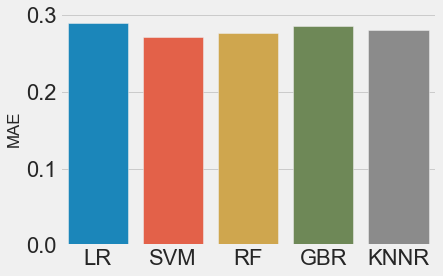

In [33]:
print(model_eval_df)
sns.barplot(x=model_eval_df.index, y=model_eval_df.MAE)